In [1]:
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import make_blobs
import networkx as nx
import matplotlib.pyplot as plt

points_count = 50
to_plot = True
no_centres = 1

In [2]:
X, Y = make_blobs(n_samples=points_count, centers=no_centres, random_state=42)
points = [(x, y) for x, y in X]
points = list(set([(round(x, 2) , round(y , 2)) for x , y in points]))

/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Time taken by fast MST: 0.05019783973693848
Total weight of the MST: 14.860014342724746 Number of edges: 48 Number of points: 50


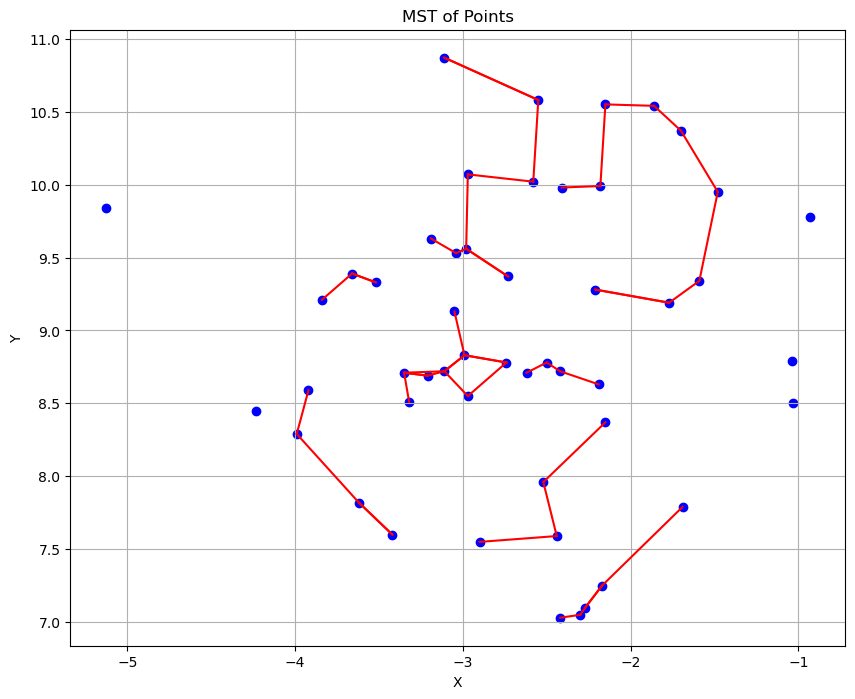

In [3]:
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree


# Define the functions and the main process as given
def euclidean_distance(p1, p2):
    return sum((a - b) ** 2 for a, b in zip(p1, p2)) ** 0.5


def detect_connecting_edge(cluster1, cluster2):
    center1 = [sum(x) / len(cluster1) for x in zip(*cluster1)]
    center2 = [sum(x) / len(cluster2) for x in zip(*cluster2)]

    min_dist1 = float("inf")
    min_point1 = None
    for point in cluster1:
        dist = euclidean_distance(point, center2)
        if dist < min_dist1:
            min_dist1 = dist
            min_point1 = point

    min_dist2 = float("inf")
    min_point2 = None
    for point in cluster2:
        dist = euclidean_distance(point, center1)
        if dist < min_dist2:
            min_dist2 = dist
            min_point2 = point

    return min_point1, min_point2


def fast_mst(points):
    n = len(points)
    k = int(n**0.5)

    # Divide-and-conquer stage
    kmeans = KMeans(n_clusters=k).fit(points)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.tolist()

    mst_edges = []
    total_weight = 0

    for i in range(k):
        cluster_points = [points[j] for j in range(n) if labels[j] == i]
        pairwise_distances = squareform(pdist(cluster_points))
        mst = minimum_spanning_tree(pairwise_distances).toarray().tolist()
        edges = [
            (u, v)
            for u in range(len(cluster_points))
            for v in range(u + 1, len(cluster_points))
            if mst[u][v] > 0
        ]
        for u, v in edges:
            weight = euclidean_distance(cluster_points[u], cluster_points[v])
            mst_edges.append((cluster_points[u], cluster_points[v]))
            total_weight += weight

    pairwise_distances_centers = squareform(pdist(centers))
    mst_centers = minimum_spanning_tree(pairwise_distances_centers).toarray().tolist()
    center_edges = [
        (i, j) for i in range(k) for j in range(i + 1, k) if mst_centers[i][j] > 0
    ]

    # Refinement stage
    midpoints = []
    for i, j in center_edges:
        cluster1 = [points[m] for m in range(n) if labels[m] == i]
        cluster2 = [points[m] for m in range(n) if labels[m] == j]
        u, v = detect_connecting_edge(cluster1, cluster2)
        mst_edges.append((u, v))
        midpoint = [(a + b) / 2 for a, b in zip(u, v)]
        midpoints.append(midpoint)
        weight = euclidean_distance(u, v)
        total_weight += weight

    kmeans_refine = KMeans(n_clusters=len(midpoints), init=midpoints, n_init=1).fit(
        points
    )
    labels_refine = kmeans_refine.labels_

    for i in range(len(midpoints)):
        cluster_points = [points[j] for j in range(n) if labels_refine[j] == i]
        pairwise_distances = squareform(pdist(cluster_points))
        mst = minimum_spanning_tree(pairwise_distances).toarray().tolist()
        edges = [
            (u, v)
            for u in range(len(cluster_points))
            for v in range(u + 1, len(cluster_points))
            if mst[u][v] > 0
        ]
        for u, v in edges:
            weight = euclidean_distance(cluster_points[u], cluster_points[v])
            mst_edges.append((cluster_points[u], cluster_points[v]))
            total_weight += weight

    return mst_edges, total_weight


# Example points (you can replace this with your own data)
# points = [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5]]

# Measure time and execute fast_mst
fmst_start_time = time.time()
mst_edges, fmst_weight = fast_mst(points)
fmst_end_time = time.time()
fmst_edgecount = len(mst_edges)
fmst_elapsed_time = fmst_end_time - fmst_start_time

print("Time taken by fast MST:", fmst_elapsed_time)
print(
    "Total weight of the MST:",
    fmst_weight,
    "Number of edges:",
    fmst_edgecount,
    "Number of points:",
    len(points),
)


# Plot the graph
def plot_graph(points, mst_edges):
    plt.figure(figsize=(10, 8))
    x, y = zip(*points)
    plt.scatter(x, y, color="blue")

    for edge in mst_edges:
        p1, p2 = edge
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color="red")

    plt.title("MST of Points")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


plot_graph(points, mst_edges)

In [3]:
n = len(points)
k = int(n**0.5)

kmeans = KMeans(n_clusters=k).fit(points)
labels = kmeans.labels_
centers = kmeans.cluster_centers_.tolist()
sub_graphs = [[] for _ in range(k)]
for point, label in zip(points, labels):
    sub_graphs[label].append(point)
print(k, len(sub_graphs))

7 7


/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [4]:
import math
import time

eprim_start_time = time.time()


def calculate_distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


def prim_mst(points):
    n = len(points)
    visited = [False] * n
    min_cost = [float("inf")] * n
    parent = [None] * n

    min_cost[0] = 0
    parent[0] = -1

    for _ in range(n):
        min_index = -1
        for i in range(n):
            if not visited[i] and (
                min_index == -1 or min_cost[i] < min_cost[min_index]
            ):
                min_index = i

        visited[min_index] = True

        for i in range(n):
            if not visited[i]:
                distance = calculate_distance(points[min_index], points[i])
                if distance < min_cost[i]:
                    min_cost[i] = distance
                    parent[i] = min_index

    mst_edges = []
    for i in range(1, n):
        mst_edges.append((parent[i], i))

    return mst_edges


mst = prim_mst(points)
eprim_end_time = time.time()
eprim_elapsed_time = eprim_end_time - eprim_start_time
print(
    "MST Weight: ",
    eprim_wt := sum([calculate_distance(points[u], points[v]) for u, v in mst]),
)
print("time taken by dcran : ", eprim_elapsed_time)

MST Weight:  17.172989154792763
time taken by dcran :  0.000997781753540039


In [5]:
msts1 = []
for graph in sub_graphs:
    msts1.append(prim_mst(graph))
    print(len(msts1[-1]) , len(graph))

8 9
9 10
7 8
7 8
5 6
7 8
0 1


In [6]:
print(centers)
mst_centres = prim_mst(centers)
print(mst_centres)

[[-2.39, 10.33], [-2.59, 8.737], [-3.2512499999999998, 9.39375], [-2.33875, 7.415], [-1.3066666666666669, 9.258333333333333], [-3.6325000000000003, 8.3325], [-5.13, 9.84]]
[(2, 1), (0, 2), (1, 3), (1, 4), (1, 5), (2, 6)]


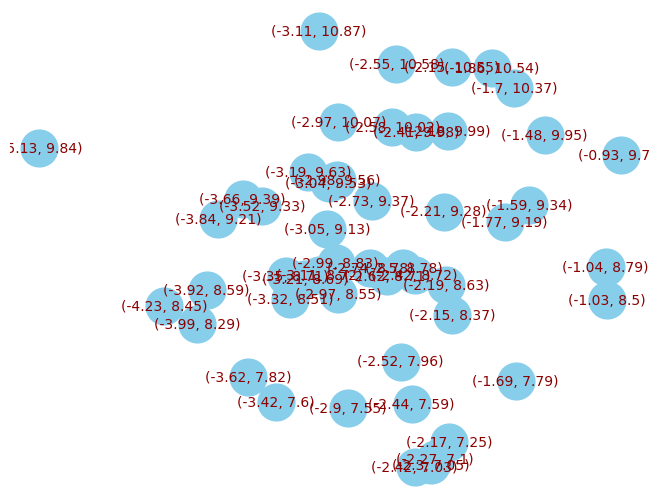

In [7]:
F = nx.Graph()
for point in points:
    F.add_node(point , pos = point)
pos = {point : point for point in points}
nx.draw(
    F,
    pos = pos,
    with_labels=True,
    node_color="skyblue",
    node_size=700,
    font_size=10,
    font_color="darkred",
)
plt.show()

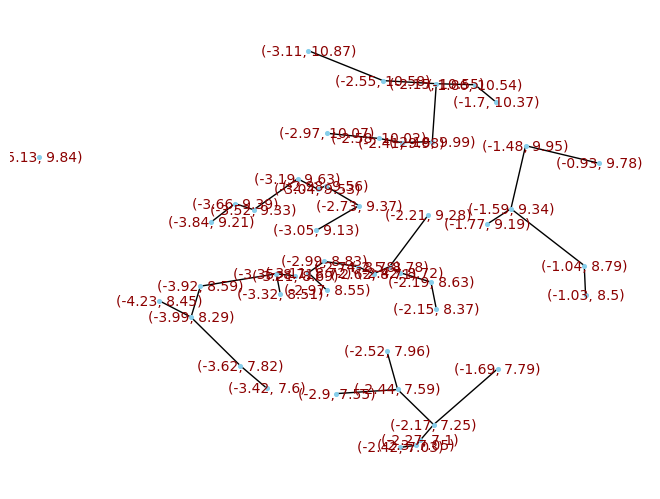

In [8]:
for sub_points , mst_edges in zip(sub_graphs , msts1):
    for u , v in mst_edges:
        F.add_edge(sub_points[u] , sub_points[v])
nx.draw(
    F,
    pos=pos,
    with_labels=True,
    node_color="skyblue",
    node_size=7,
    font_size=10,
    font_color="darkred",
)
plt.show()

In [9]:
import math
def connect(sg1 , sg2):
    centroid = (sum([x for x , y in sg1])/len(sg1) , sum([y for x , y in sg1])/len(sg1))
    def closest_point(sg2, centroid):
        min_distance = float('inf')
        closest_point = None
        
        for point in sg2:
            distance = math.sqrt((point[0] - centroid[0]) ** 2 + (point[1] - centroid[1]) ** 2)
            if distance < min_distance:
                min_distance = distance
                closest_point = point
        
        return closest_point

    closest_point_sg2 = closest_point(sg2, centroid)
    closest_point_sg1 = closest_point(sg1, closest_point_sg2)
    print(closest_point_sg1 , closest_point_sg2)    
    F.add_edge(closest_point_sg1 , closest_point_sg2)
    

In [10]:
new_centres = []
for s , e in mst_centres:
    connect(sub_graphs[s] , sub_graphs[e])
    mid_point = ((centers[s][0] + centers[e][0])/2 , (centers[s][1] + centers[e][1])/2)
    new_centres.append(mid_point)
print(new_centres)

(-3.05, 9.13) (-2.99, 8.83)
(-2.97, 10.07) (-2.98, 9.56)
(-2.15, 8.37) (-2.52, 7.96)
(-2.21, 9.28) (-1.77, 9.19)
(-3.11, 8.72) (-3.21, 8.69)
(-3.84, 9.21) (-5.13, 9.84)
[(-2.920625, 9.065375), (-2.8206249999999997, 9.861875000000001), (-2.464375, 8.076), (-1.9483333333333333, 8.997666666666667), (-3.11125, 8.534749999999999), (-4.190625, 9.616875)]


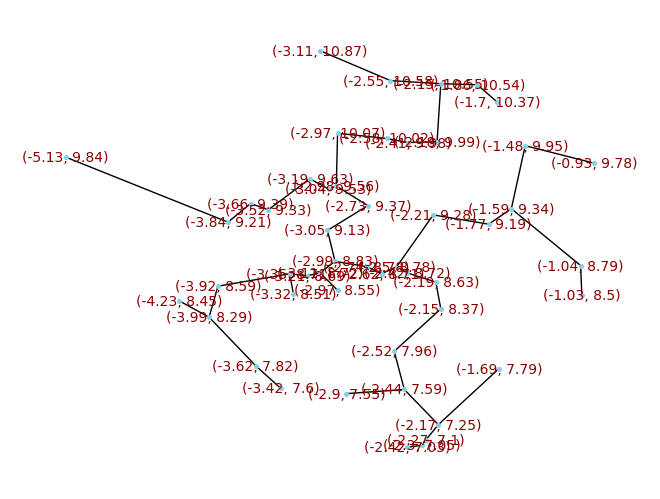

In [11]:
nx.draw(
    F,
    pos=pos,
    with_labels=True,
    node_color="skyblue",
    node_size=7,
    font_size=10,
    font_color="darkred",
)
plt.show()

In [12]:
kmeans2 = KMeans(n_clusters=len(new_centres), init=new_centres, n_init=1)
kmeans2.fit(new_centres)
labels2 = kmeans2.predict(points)

sub_graphs2 = [[] for _ in range(len(new_centres))]
for point, label in zip(points, labels2):
    sub_graphs2[label].append(point)    
print(len(sub_graphs2))



6


In [13]:
mst2 = []
for graph in sub_graphs2:
    mst2.append(prim_mst(graph))
    print(len(mst2[-1]) , len(graph))

6 7
11 12
8 9
8 9
9 10
2 3


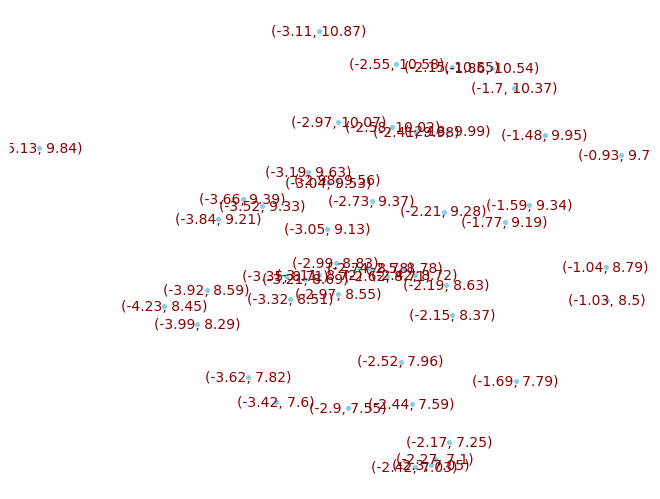

In [14]:
G = nx.Graph()
for point in points:
    G.add_node(point , pos = point)
pos = {point : point for point in points}
nx.draw(
    G,
    pos = pos,
    with_labels=True,
    node_color="skyblue",
    node_size=7,
    font_size=10,
    font_color="darkred",
)
plt.show()

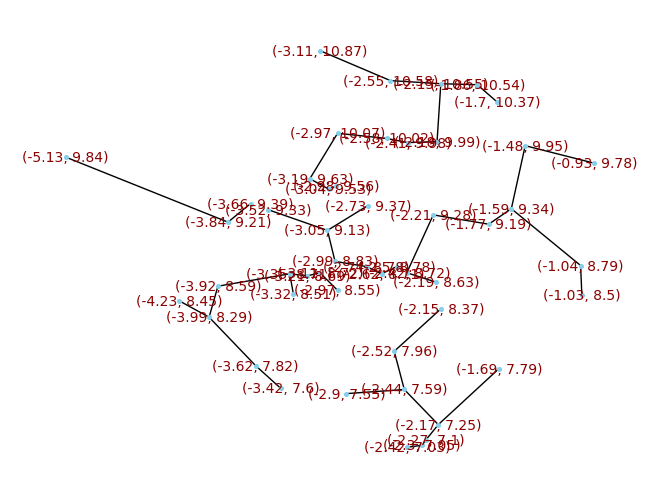

In [15]:
for sub_points , mst_edges in zip(sub_graphs2 , mst2):
    for u , v in mst_edges:
        G.add_edge(sub_points[u] , sub_points[v])
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color="skyblue",
    node_size=7,
    font_size=10,
    font_color="darkred",
)
plt.show()

In [17]:
a = [13 , 4 ,6]
b = [lambda x : x**2 for x in a]